# Crossover Trading Strategy on S&P 500 Stocks
Compare the Crossover strategy aginst simply holding the stock using all the stocks in the S&P 500. 

In [63]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

In [64]:
start = datetime.datetime(2011,1,1)
end = datetime.date.today()
'script ran on ' +  end.strftime('%Y-%m-%d')

'script ran on 2017-02-13'

In [65]:
%matplotlib inline
#%matplotlib notebook

In [66]:
def price_adj(dat):
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})

In [67]:
def gen_stock_pnl(stock_symbols):
    if type(stock_symbols) == list:
        for stock in stock_symbols:
            prices = web.DataReader(stock, 'yahoo', start, end)
            yield stock, price_adj(prices)

From [Wikipedia list of S&P 500](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). 

In [68]:
sp500 = pd.read_csv('data in/sp500.csv')

In [69]:
sp500.head()

,Ticker symbol,Security,GICS Sector,GICS Sub Industry
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie,Health Care,Pharmaceuticals
3,ACN,Accenture plc,Information Technology,IT Consulting & Other Services
4,ATVI,Activision Blizzard,Information Technology,Home Entertainment Software


In [70]:
sp500['GICS Sector'].value_counts()

Consumer Discretionary         86
Industrials                    70
Information Technology         65
Financials                     65
Health Care                    59
Consumer Staples               37
Energy                         36
Real Estate                    29
Utilities                      28
Materials                      25
Telecommunications Services     5
Name: GICS Sector, dtype: int64

In [71]:
sp500_prices = pd.Panel(dict(gen_stock_pnl(sp500['Ticker symbol'].tolist())))

In [72]:
# The process to get from stock prices to trade signals and profits, is better organized within a class. 
class Stock:
    def __init__(self, prices):
        self.price_df = prices.copy()
        
    def get_regimes(self, fast, slow):
        fast_str = str(fast) + 'd'
        slow_str = str(slow) + 'd'
        ma_diff_str = fast_str + '-' + slow_str
        self.price_df[fast_str] = self.price_df["Close"].rolling(window = fast, center = False).mean()
        self.price_df[slow_str] = self.price_df["Close"].rolling(window = slow, center = False).mean()
        self.price_df[ma_diff_str] = self.price_df[fast_str] - self.price_df[slow_str]
 
        self.price_df["Regime"] = np.sign(self.price_df[ma_diff_str])
        self.price_df["Regime"] = self.price_df["Regime"].fillna(0)
    
    def add_signals(self):
        self.price_df["Signal"] = np.sign(self.price_df["Regime"] - self.price_df["Regime"].shift(1))
                
    def get_trade_df(self, fast, slow):
        self.get_regimes(fast, slow)
        self.add_signals()
        trades = pd.concat([
            pd.DataFrame({"Price": self.price_df.loc[self.price_df["Signal"] == 1, "Close"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": self.price_df.loc[self.price_df["Signal"] == -1, "Close"],
                         "Signal": "Sell"}),
            ])
        trades.sort_index(inplace = True)
        # can't sell before we buy
        if trades.ix[0, 'Signal'] == 'Sell':
            trades = trades.iloc[1:]
        if trades.ix[-1, 'Signal'] == 'Buy':
            # if the signal of the last day is buy, just don't buy it, otherwise sell on the last day.
            last_date = self.price_df.index[-1]
            if trades.ix[-1].name == last_date:
                trades = trades.iloc[:-1]
            else:
                # This is screwing up the "name" of the index causing the error...
                trades = trades.append(pd.Series({'Price':self.price_df.ix[-1,'Close'], 'Signal':'Sell'}, name=last_date))
                trades.index.name = 'Date'
        return trades
        
    def get_profits(self, fast, slow):
        stock_signals = self.get_trade_df(fast, slow)
        buy_df = stock_signals[stock_signals['Signal']=='Buy'].reset_index().copy()
        sell_df = stock_signals[stock_signals['Signal']=='Sell'].reset_index().copy()
        buy_df = buy_df.drop('Signal', axis=1)
        buy_df['End Date'] = sell_df['Date']
        buy_df['Profit'] = sell_df['Price'] - buy_df['Price']
        return buy_df.set_index('Date')

In [73]:
sp500 = sp500.set_index('Ticker symbol')

In [74]:
for symbol, price_df in sp500_prices.iteritems():
    stock_cls = Stock(price_df)
    alg_profit = stock_cls.get_profits(20,50)['Profit'].sum()
    sp500.loc[symbol, 'alg profit'] = alg_profit
    # filter out null values when stock was not on market
    price_df = price_df[~np.isnan(price_df['Close'])]
    stock_hold_profit = price_df.ix[-1, 'Close'] - price_df.ix[0, 'Close']
    sp500.loc[symbol, 'hold profit'] = stock_hold_profit
    sp500.loc[symbol, 'hold return'] = price_df.ix[-1, 'Close'] / price_df.ix[0, 'Close']
    sp500.loc[symbol, 'alg return'] = (price_df.ix[0, 'Close'] + alg_profit) / price_df.ix[0, 'Close']

In [75]:
sp500.head()

,Security,GICS Sector,GICS Sub Industry,alg profit,hold profit,hold return,alg return
Ticker symbol,,,,,,,
MMM,3M Company,Industrials,Industrial Conglomerates,70.708532,104.363707,2.398297,1.947375
ABT,Abbott Laboratories,Health Care,Health Care Equipment,0.103761,23.182386,2.185338,1.005305
ABBV,AbbVie,Health Care,Pharmaceuticals,4.081111,30.229457,2.001289,1.135178
ACN,Accenture plc,Information Technology,IT Consulting & Other Services,13.332207,75.058632,2.764368,1.313394
ATVI,Activision Blizzard,Information Technology,Home Entertainment Software,25.987473,35.559795,4.047058,3.226822


In [76]:
sp500.describe()

,alg profit,hold profit,hold return,alg return
count,505.000000,505.000000,505.000000,505.000000
mean,22.665883,51.188938,2.330279,1.616644
std,43.996777,85.983478,1.232864,0.832553
min,-79.390010,-99.930001,0.232253,-0.518762
25%,2.158568,16.402266,1.565404,1.065979
50%,14.165820,34.102637,2.184275,1.459102
75%,29.491714,60.605850,2.735857,1.926101
max,388.059953,1230.520020,10.640745,6.634432


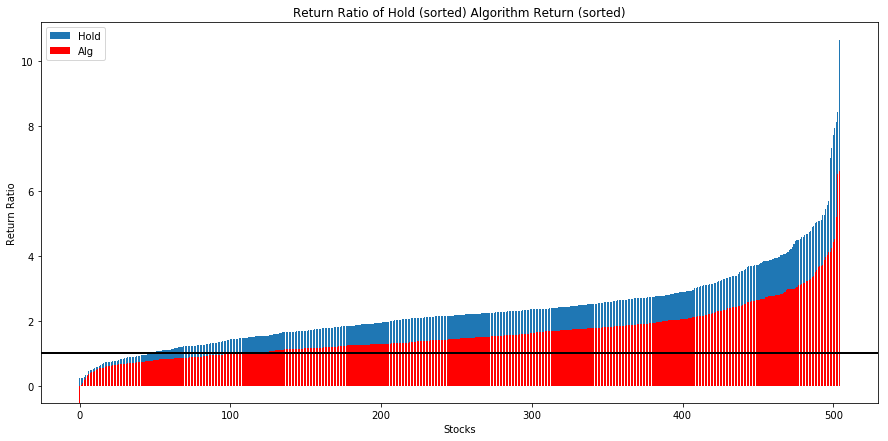

In [77]:
plt.figure(figsize=(15,7)) 
plt.bar(np.arange(sp500['hold return'].count()), sp500['hold return'].sort_values(), label='Hold')
plt.bar(np.arange(sp500['alg return'].count()), sp500['alg return'].sort_values(), label='Alg', color='r')
plt.axhline(y=1, color='black', lw=2)
plt.ylabel('Return Ratio')
plt.xlabel('Stocks')
plt.legend()
plt.title('Return Ratio of Hold (sorted) Algorithm Return (sorted)')

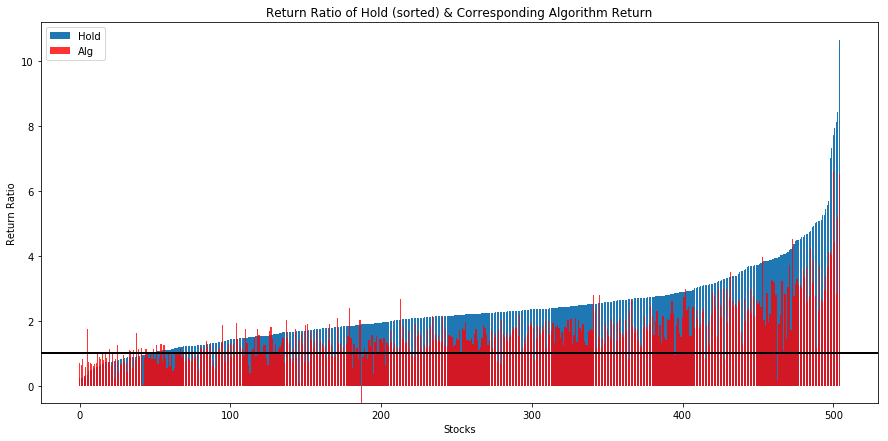

In [78]:
def plot_returns():
    plt.figure(figsize=(15,7)) 
    df = sp500.sort_values('hold return')
    plt.bar(np.arange(df['hold return'].count()), df['hold return'], label='Hold')
    plt.bar(np.arange(df['alg return'].count()), df['alg return'], label='Alg', alpha=0.8, color='r')
    plt.axhline(y=1, color='black', lw=2)
    plt.ylabel('Return Ratio')
    plt.xlabel('Stocks')
    plt.legend()
    plt.title('Return Ratio of Hold (sorted) & Corresponding Algorithm Return')
plot_returns()

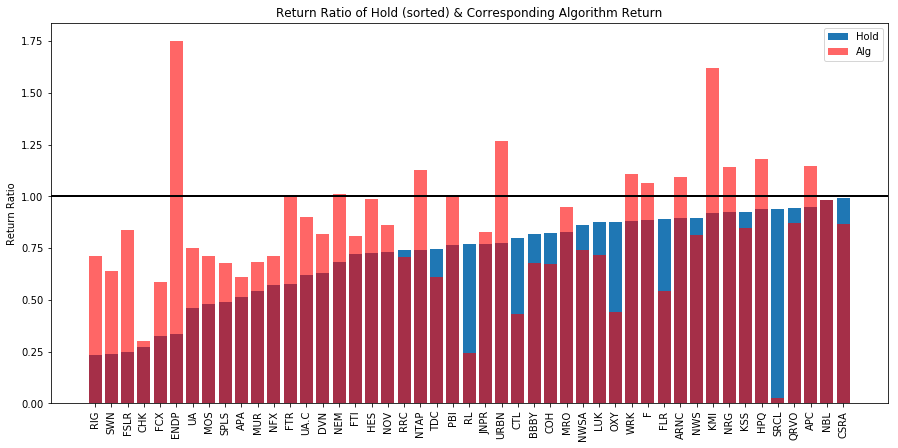

In [79]:
def plot_returns():
    plt.figure(figsize=(15,7))
    df = sp500.sort_values('hold return')
    df = df[df['hold return']<1]
    plt.bar(np.arange(df['hold return'].count()), df['hold return'], label='Hold')
    plt.bar(np.arange(df['alg return'].count()), df['alg return'], label='Alg', alpha=0.6, color='r')
    plt.axhline(y=1, color='black', lw=2)
    plt.ylabel('Return Ratio')
    plt.legend()
    plt.title('Return Ratio of Hold (sorted) & Corresponding Algorithm Return')
    plt.xticks(np.arange(len(df)))
    plt.gca().set_xticklabels(df.index)
    plt.xticks(rotation=90)
plot_returns()

It appears that the alg outperforms holding the stock when holding results in a loss. Let's breakdown those numbers.

In [80]:
def pivot_stocks():
    df = pd.DataFrame((sp500['hold return']<1).values, columns=['hold loss'])
    df['alg > hold'] = (sp500['alg profit'] > sp500['hold profit']).values
    return df.pivot_table(index='hold loss', columns='alg > hold', aggfunc=len, margins=True)

pivot_stocks()

alg > hold,False,True,All
hold loss,,,
False,429.0,29.0,458.0
True,16.0,31.0,47.0
All,445.0,60.0,505.0


In [81]:
def pivot_percentages():
    pt_vals = pivot_stocks()
    return pt_vals.div(pt_vals.iloc[:,-1], axis=0) * 100
pivot_percentages()

alg > hold,False,True,All
hold loss,,,
False,93.668122,6.331878,100.0
True,34.042553,65.957447,100.0
All,88.118812,11.881188,100.0


This trading strategy only beat holding the stock in 12% of the stocks tested. 

When holding the stock resulted in a loss, the trading strategy outperformed it more often than not. The trading strategy may be a way to limit loss and risk over holding a stock. 

## Potential Losses
Trip Advisor has a negative return ratio (i.e., losses over multiple trades were more than 100% of the initial stock value). There's no loss cuttoff in the algorithm.   

In [82]:
sp500[sp500['alg return']<0]

,Security,GICS Sector,GICS Sub Industry,alg profit,hold profit,hold return,alg return
Ticker symbol,,,,,,,
TRIP,TripAdvisor,Consumer Discretionary,Internet & Direct Marketing Retail,-41.690011,24.549999,1.894353,-0.518762


In [83]:
Stock(sp500_prices['TRIP']).get_profits(20,50)['Profit']

Date
2012-02-17     5.309997
2012-11-20    24.990001
2013-07-29     8.379997
2014-02-20   -17.810005
2014-05-30    -3.299995
2014-09-19    -4.080002
2015-01-14     1.390000
2015-02-19    -7.690003
2015-06-25   -13.490006
2015-10-20   -12.330002
2016-03-29    -1.890003
2016-05-24    -1.769997
2016-07-22    -8.039997
2016-10-10   -11.969997
2017-01-23     0.610001
Name: Profit, dtype: float64

## Correlation between stocks

In [84]:
sp500_prices.loc[:,:,'Close'].corr().head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
A,1.000000,0.847678,0.835415,0.727631,0.805440,0.799781,0.789756,0.853001,0.915566,0.896317,...,0.894012,0.709867,0.875849,0.750195,0.930296,0.884225,0.821559,0.927268,0.821348,0.699335
AAL,0.847678,1.000000,0.934468,0.873537,0.806486,0.934546,0.921019,0.827967,0.890106,0.891986,...,0.814680,0.637855,0.849191,0.798230,0.765537,0.917483,0.805536,0.915571,0.729556,0.641558
AAP,0.835415,0.934468,1.000000,0.896492,0.899550,0.929810,0.906574,0.902126,0.934295,0.910290,...,0.819117,0.550839,0.920974,0.670261,0.808901,0.848132,0.848518,0.907993,0.685263,0.807113
AAPL,0.727631,0.873537,0.896492,1.000000,0.892428,0.879273,0.892899,0.818345,0.837828,0.857335,...,0.701679,0.501693,0.814540,0.563948,0.695074,0.777321,0.856263,0.839471,0.587580,0.858566
ABBV,0.805440,0.806486,0.899550,0.892428,1.000000,0.839740,0.867542,0.789633,0.865139,0.823539,...,0.580311,0.113585,0.820903,0.471487,0.754322,0.762015,0.814725,0.902602,0.391017,0.871502


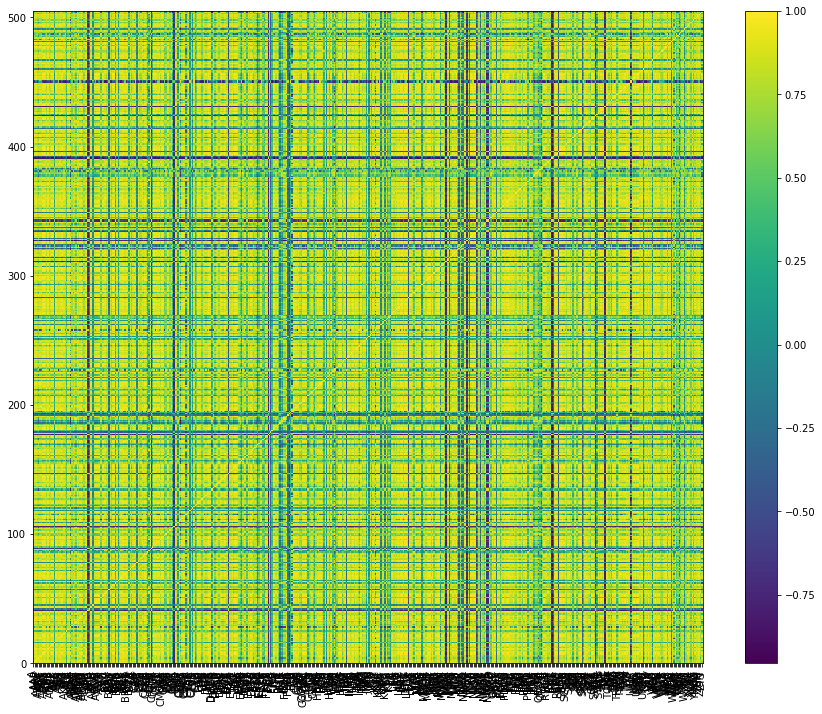

In [85]:
def gen_corr_vis():
    df = sp500_prices.loc[:,:,'Close'].corr()
    plt.figure(figsize=(15,12)) 
    plt.pcolor(df)
    plt.colorbar()
    plt.xticks(np.arange(len(df)))
    plt.gca().set_xticklabels(df.columns)
    plt.xticks(rotation=90)
    #plt.savefig('data out/correlation chart', dpi=3000)
    
gen_corr_vis()